In [30]:
import numpy as np
import pandas as pd
import itertools
import os
import glob
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
path_folder = "../data/raw/"  # path to the folder containing the data
path_out = (
    "../data/outputs/data_light_raw/"  # path to the folder to store the light data
)
output_dir = "../data/outputs/data_light_raw/"

if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

Directory ../data/outputs/data_light_raw/ already exists.


# DATA CALIBRATION FUNCTIONS

In [12]:
CHUNKS_SIZE = 2

In [45]:
def adc_revert(signal: np.ndarray, gain: float, offset: float) -> np.ndarray:
    """Revert pixel voltage from ADC.

    Args:
        signal (np.ndarray): ADC converted signal integer.
        gain (float): ADC gain error.
        offset (float): ADC offset error.

    Returns:
        np.ndarray: Pixel voltages.
    """

    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal


# TODO: There is some methods to correct bad pixels. Keep that in mind
def mask_hot_dead(signal: np.ndarray, dead: np.ndarray, dark: np.ndarray) -> np.ndarray:
    """Mask dead and hot pixels so that they won't be take in account in corrections.

    Args:
        signal (np.ndarray): Pixel voltage signal.
        dead (np.ndarray): Dead pixels.
        dark (np.ndarray): Dark pixels.

    Returns:
        np.ndarray: Pixel voltages with dead pixels masked.
    """
    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal


def apply_linear_corr(corr: np.ndarray, signal: np.ndarray) -> np.ndarray:
    """Fix non-linearity due to capacity leakage in the detector.

    Args:
        corr (np.ndarray): Correction coefficients
        signal (np.ndarray): Signal to correct.

    Returns:
        np.ndarray: Corrected signal
    """
    linear_corr = np.flip(corr, axis=0)
    for x, y in itertools.product(range(signal.shape[1]), range(signal.shape[2])):
        poli = np.poly1d(linear_corr[:, x, y])
        signal[:, x, y] = poli(signal[:, x, y])
    return signal


def clean_dark_current(
    signal: np.ndarray, dead: np.ndarray, dark: np.ndarray, dt: np.array
) -> np.ndarray:
    """Remove the accumulated charge due to dark current.

    Args:
        signal (np.ndarray): Signal to clean
        dead (np.ndarray): Dead pixels.
        dark (np.ndarray): Dark pixels.
        dt (np.array): Short frames delay.

    Returns:
        np.ndarray: Cleaned signal.
    """
    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal


def get_cds(signal: np.ndarray) -> np.ndarray:
    """Return the actual accumulated charge (a delta) due to the transit.

    Args:
        signal (np.ndarray): Signal.

    Returns:
        np.ndarray: An image for one observation in the time (Time series observations).
    """
    cds = signal[:, 1::2, :, :] - signal[:, ::2, :, :]
    return cds


# TODO: This function is optionnal in the processing
def bin_obs(cds: np.ndarray, binning: int) -> np.ndarray:
    """Binnes cds time series together at the specified frequency.

    Args:
        cds (np.ndarray): CDS signal.
        binning (int): Binning frequency.

    Returns:
        np.ndarray: _description_
    """
    cds_transposed = cds.transpose(0, 1, 3, 2)
    cds_binned = np.zeros(
        (
            cds_transposed.shape[0],
            cds_transposed.shape[1] // binning,
            cds_transposed.shape[2],
            cds_transposed.shape[3],
        )
    )
    for i in range(cds_transposed.shape[1] // binning):
        cds_binned[:, i, :, :] = np.sum(
            cds_transposed[:, i * binning : (i + 1) * binning, :, :], axis=1
        )
    return cds_binned


def correct_flat_field(flat: np.ndarray, dead: np.ndarray, signal: np.ndarray):
    """Correction by calibrating on an uniform signal.

    Args:
        flat (np.ndarray): Flat signal
        dead (np.ndarray): Dead pixels
        signal (np.ndarray): CDS signal
    """

    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal


# TODO: Correct electronic noise

# DATA CALIBARATION

In [7]:
def get_index(files, CHUNKS_SIZE):
    index = []
    for file in files:
        file_name = file.split("/")[-1]
        if (
            file_name.split("_")[0] == "AIRS-CH0"
            and file_name.split("_")[1] == "signal.parquet"
        ):
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index)
    # credit to DennisSakva
    index = np.array_split(index, len(index) // CHUNKS_SIZE)

    return index

In [13]:
files = glob.glob(os.path.join(path_folder + "train/", "*/*"))

index = get_index(files[:22], CHUNKS_SIZE)

In [15]:
train_adc_info = pd.read_csv(os.path.join(path_folder, "train_adc_info.csv"))
train_adc_info = train_adc_info.set_index("planet_id")
axis_info = pd.read_parquet(os.path.join(path_folder, "axis_info.parquet"))

In [20]:
train_adc_info.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star
planet_id,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1
14485303,-366.381992,0.842983,-740.323212,0.931727,1
17002355,-386.107037,1.041701,-808.690659,1.513541,0
24135240,-339.737490,0.840239,-776.124167,0.931277,1
25070640,-355.660433,1.041280,-848.371494,1.503923,0


En fait pour optimiser le stockage des données, les pixels de base en Volt sont convertis en nombre entier selon la méthode ADC. les données de `[train/test]_adc_info` permettent de revenir au signal de base en volt pour chaque type d'instrument et pour chaque planète.

In [21]:
axis_info.head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


In [23]:
len(axis_info["AIRS-CH0-integration_time"].dropna())

11250

`axis_info` contient les info pour pouvoir identifier quels frames concernent une observation. pour le capteur FGS1 le delai est constant et de `0.1`. pour le capteur AIRS-CHO, il est donnée par la colonne `AIRS-CH0-integration_time`. chaque ligne de cette colonne correspond à un frame observé du signal.

In [17]:
df = pd.read_parquet(
    os.path.join(path_folder, f"train/{index[0][0]}/AIRS-CH0_signal.parquet")
)

In [19]:
gain = train_adc_info["AIRS-CH0_adc_gain"].loc[index[0][0]]
offset = train_adc_info["AIRS-CH0_adc_offset"].loc[index[0][0]]

In [18]:
df

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,1313,1282,1248,1279,1291,1341,1283,1248,1301,1288,...,1295,1280,1327,1285,1284,1280,1306,1252,1272,1304
1,1277,1305,1334,1305,1279,1319,1282,1260,1255,1274,...,1284,1288,1290,1262,1345,1292,1273,1299,1291,1280
2,1290,1268,1279,1289,1295,1278,1262,1276,1275,1299,...,1270,1236,1302,1290,1305,1273,1276,1274,1262,1291
3,1298,1295,1278,1285,1286,1294,1291,1301,1321,1302,...,1330,1292,1268,1296,1269,1254,1319,1263,1292,1290
4,1294,1271,1300,1280,1272,1240,1273,1307,1299,1311,...,1282,1272,1275,1296,1253,1256,1277,1268,1313,1312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,1292,1293,1283,1254,1271,1270,1272,1272,1288,1288,...,1262,1270,1289,1281,1291,1302,1291,1282,1307,1272
11246,1290,1303,1296,1307,1303,1281,1277,1273,1279,1258,...,1314,1279,1297,1271,1249,1263,1286,1291,1293,1305
11247,1291,1282,1308,1286,1266,1285,1255,1245,1332,1259,...,1278,1291,1264,1294,1270,1295,1301,1287,1307,1297
11248,1289,1300,1272,1310,1232,1282,1265,1298,1301,1272,...,1269,1297,1261,1259,1277,1239,1264,1295,1299,1318


Une ligne du DataFrame correspond à une image `32 x 356` applatie.
Normalement la différence entre deux de ces images correspond au CDS.

In [69]:
signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))

Text(0.5, 1.0, 'Observation unique ADC')

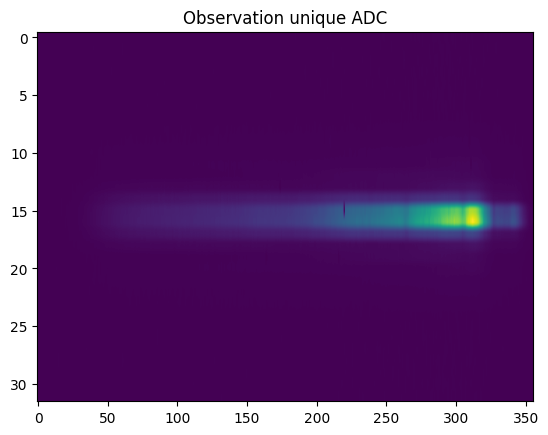

In [70]:
plt.imshow(signal[7], aspect="auto")
plt.title("Observation unique ADC")

In [71]:
signal = adc_revert(signal, gain, offset)

Text(0.5, 1.0, 'Observation unique')

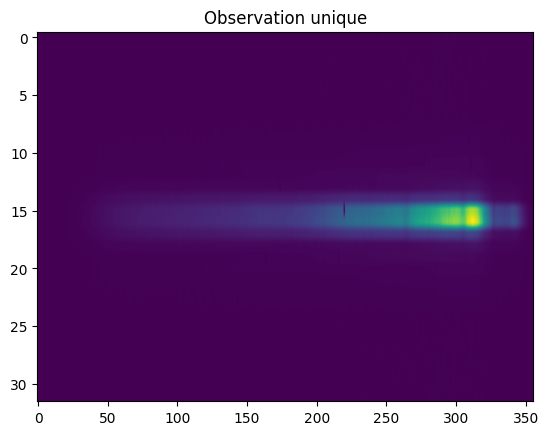

In [72]:
plt.imshow(signal[7], aspect="auto")
plt.title("Observation unique")

In [73]:
dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values
dt_airs[1::2] += 0.1  # coorection to consider dark current accumulatio dt
signal = signal[:, :, 39:321]  # Pour avoir des images 32 x 282 comme FGS1

In [75]:
flat = (
    pd.read_parquet(
        os.path.join(
            path_folder,
            f"train/{index[0][0]}/AIRS-CH0_calibration/flat.parquet",
        )
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, 39:321]
)

Text(0.5, 1.0, 'Flat')

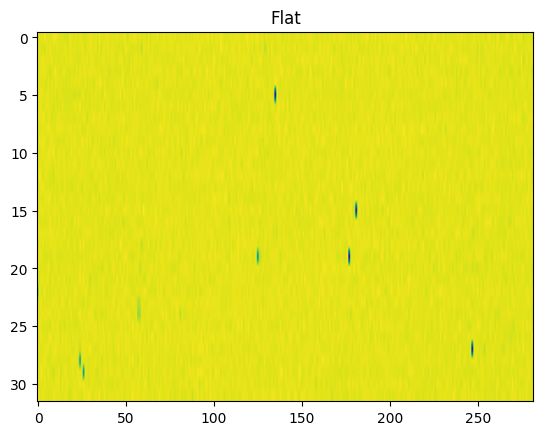

In [79]:
plt.imshow(flat, aspect="auto")
plt.title("Flat")

Text(0.5, 1.0, 'Darks')

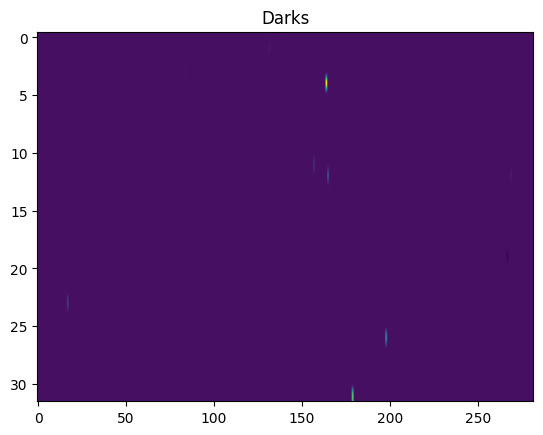

In [82]:
dark = (
    pd.read_parquet(
        os.path.join(
            path_folder,
            f"train/{index[0][0]}/AIRS-CH0_calibration/dark.parquet",
        )
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, 39:321]
)
plt.imshow(dark, aspect="auto")
plt.title("Darks")

Text(0.5, 1.0, 'Dead')

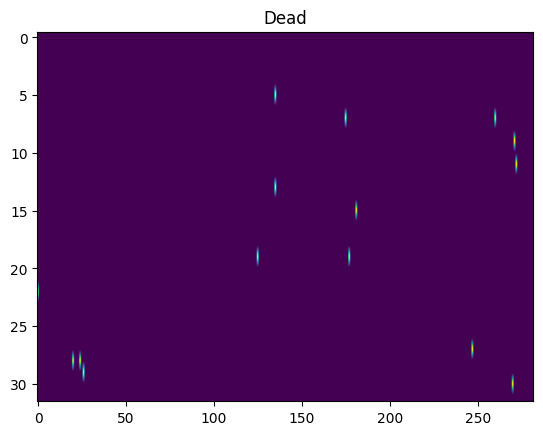

In [84]:
dead_airs = (
    pd.read_parquet(
        os.path.join(
            path_folder,
            f"train/{index[0][0]}/AIRS-CH0_calibration/dead.parquet",
        )
    )
    .values.astype(np.float64)
    .reshape((32, 356))[:, 39:321]
)
plt.imshow(dead_airs, aspect="auto")
plt.title("Dead")

Text(0.5, 1.0, 'Linear coorection')

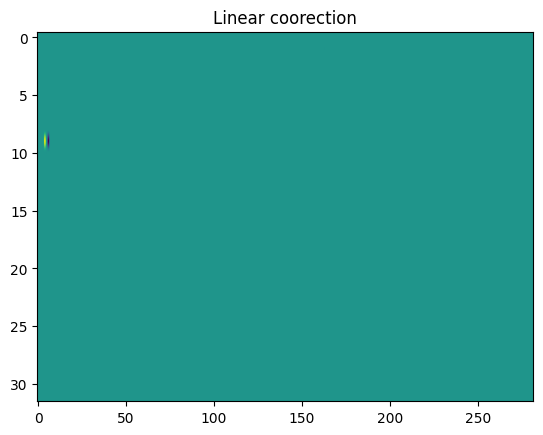

In [90]:
linear_corr = (
    pd.read_parquet(
        os.path.join(
            path_folder,
            f"train/{index[0][0]}/AIRS-CH0_calibration/linear_corr.parquet",
        )
    )
    .values.astype(np.float64)
    .reshape((6, 32, 356))[:, :, 39:321]
)
plt.imshow(linear_corr[0], aspect="auto")
plt.title("Linear coorection")

In [97]:
cds = signal[1::2, :, :] - signal[::2, :, :]

Text(0.5, 1.0, 'CDS')

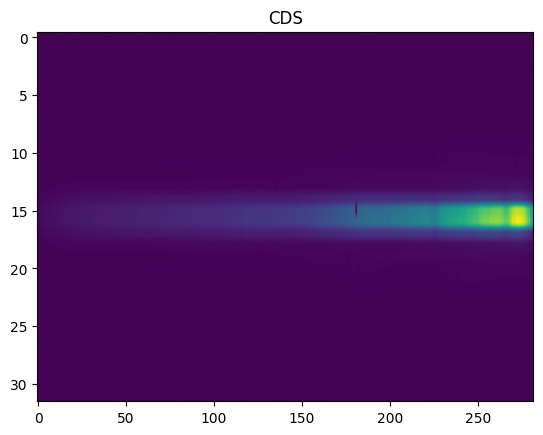

In [98]:
plt.imshow(cds[4], aspect="auto")
plt.title("CDS")